# Solving The Checkerboard Artifacts In Image Deconvolution
This notebook demonstrate the NormConvTranspose2d implementation and the results of the EDSR and WDSR
networks which were trained using this new approach

Start by installing all dependencies (if your env contain the required dependencies, skip this part)

In [33]:
from argparse import Namespace
!pip3 install -r requirements.txt --user
!pip3 install torch --user
!pip3 install matplotlib --user

  Using cached tensorboard-2.2.0-py3-none-any.whl (2.8 MB)
  Using cached numpy-1.17.0.zip (6.5 MB)
  Using cached h5py-2.10.0-cp38-cp38-macosx_10_9_x86_64.whl (3.0 MB)
  Using cached tqdm-4.38.0-py2.py3-none-any.whl (53 kB)
  Using cached Pillow-5.3.0.tar.gz (15.6 MB)
anceled
ERROR: Operation cancelled by user


and we import the required libs

In [9]:
import numpy as np
from torch import nn
import torch
import matplotlib.pyplot as plt

We will start with a simple demonstration of the normalization of the deconvolution.

We define two deconvolutions layers:
 - one using nn.ConvTranspose2d implementation
 - one with our own implementation - NormConvTranspose2d

We initialize both with the same weights and biases to be able to properly compare between them.
We initialize with a flat value convolution and with bias 0.

In [3]:
from core.model.NormConvTranspose2d import NormConvTranspose2d

deconv = nn.ConvTranspose2d(3, 3, kernel_size=5, stride=4, padding=2, output_padding=3)
norm_deconv = NormConvTranspose2d(3, 3, kernel_size=5, stride=4, padding=2, output_padding=3)

deconv.weight.data.fill_(0.4)
norm_deconv.weight.data.fill_(0.4)
deconv.bias.data.fill_(0)
norm_deconv.bias.data.fill_(0)


tensor([0., 0., 0.])

For the following experiment demonstration, the deconv will run over a 20x20x3 homogeneous color image.<br>

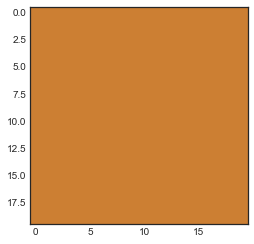

In [32]:
img = torch.zeros((1, 3,20,20))
img[0][0] = 0.8
img[0][1] = 0.5
img[0][2] = 0.2

plt.imshow(img.squeeze().permute(1, 2, 0))

We would expect to demonstrate checkerboard artifacts in the nn.ConvTranspose2d one.<br>
In our NormConvTranspose2d, we would expect to demonstrate mitigated artifacts.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


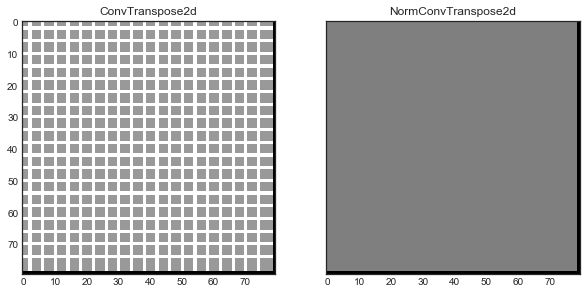

In [30]:
%matplotlib inline
plt.style.use('seaborn-white')

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=[10, 7])
res_deconv = deconv(img)
res_norm_deconv = norm_deconv(img)
ax[0].imshow(res_deconv.squeeze().permute(1, 2, 0).detach())
ax[0].title.set_text("ConvTranspose2d")
ax[1].imshow(res_norm_deconv.squeeze().permute(1, 2, 0).detach())
ax[1].title.set_text("NormConvTranspose2d")

One can easily, when comparing the results of ConvTranspose2d implementation with NormConvTranspose2d implementation that the checkerboard artifacts are mitigated.<br>
This implies that notion of adding a normalization step is indeed beneficial.

# EDSR Model

We have implemented and trained the EDSR and WDSR models with Deconvolution and Normalized Deconvolution.<br>
The results are also brought in the attached paper and the github repository.<br><br><br><br>
## Results
![Results](./images/result_examples.png)

## Run the model
The pretrained models are available on S3.<br>
To run an evaluation test, please download an EDSR model file and place it in you local drive.

In [6]:
!wget s3://deconv-pretrained/EDSR-Norm-Deconv-f128-b32-r4-x4-new-best.pth.tar .


/bin/sh: wget: command not found


Then, run the following cell:

In [7]:
from core.EDSR.edsr import EDSR
from argparse import Namespace
from eval import test
from core.utils import *
from core.data.dir_dataset import DirDataSet
from torch.utils.data.dataloader import DataLoader


args = Namespace(augment_patch=True, batch_size=16,
                 checkpoint_file='./EDSR-Norm-Deconv-f128-b32-r4-x4-new-best.pth.tar',
                 dataset_dir='data/div2k/', debug=False, deconv=True, epochs=300,
                 expansion_ratio=4, iterations_per_epoch=1000, low_rank_ratio=0.8,
                 lr=0.001, lr_decay_gamma=0.5, lr_decay_steps=200,
                 model='EDSR-Norm-Deconv', n_feats=128, n_res_blocks=32, norm=True,
                 num_workers=4, output_dir='images/results/',
                 patch_size=96, res_scale=1.0, rgb_mean=[0.4488, 0.4371, 0.404],
                 rgb_range=(0.0, 255.0), scale=4, seed=1, self_ensemble=False,
                 subtract_mean=True)

model = EDSR(args).to('cpu')

# Load weights
model = load_weights(model, load_checkpoint(args.checkpoint_file)['state_dict'])

# Prepare dataset
dataset = DirDataSet('images/sample')
#dataset = DIV2K(args, train=False)
dataloader = DataLoader(dataset=dataset, batch_size=1)

test(dataset, dataloader, model, args, 'cpu')

FileNotFoundError: [Errno 2] No such file or directory: './EDSR-Norm-Deconv-f128-b32-r4-x4-new-best.pth.tar'